## Random Unitary Circuit (Brute Force Simulation)

Jinsu Zhang


In [130]:
import numpy as np 
from scipy import sparse
from scipy.sparse.linalg import eigsh, svds
from scipy.stats import unitary_group
import random
from numba import jit
from scipy.sparse import coo_matrix, csr_matrix
from scipy.linalg import svdvals,svd
from timeit import default_timer as timer

In [582]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as snb

Reference: https://github.com/empyriumz/Entanglement-Dynamics

We first optimized the code and we have ``unitary old`` and ``unitary_basic`` function. Then we tried to remove the kronecker product, so we have ``unitary``.


## Unitary Function

Consider a single layer.

In ``unitary(wave, length)`` function, length = system + ancilla. The system is a 1D spin chain with local hamiltonian q = 2. You can define how many ancilla qubits to be coupled with the system. 

The first loop is to calculate all the gates (systemsize / 2) on the layer.

Use ``singleunitary = unitary_group.rvs(4)`` to generate all unitary gates on two-qubit sites.

Use ``wave = np.matmul(singleunitary, wave.reshape(4, 2 ** (length - 2)))``  to $(U \otimes I_{2^{l - 2}}) |\psi\rangle$. It's even better by using ``tensordot`` function. 

The wave is an array with system (may be plus ancilla). Generally, we want to perform gate on the first two qubits. We used ``reshape`` to move our target "qubits" to the first two. Then, we apply the gate. After the gate was performed, we move the qubits back by using ``transpose(1, 0, 2)`` to their original positions. When we have ancilla qubits, we need to keep ancilla qubits fixed.

Finally, we use ``wave.flatten()`` to make the wave back to an array.

In [131]:
def unitary_old(wave, x, l): 
    for i in range(l):
        wavesplit = wave.reshape(2**(2*x), 2**(l-2*x))
        singleunitary = unitary_group.rvs(4)
        applyunitarytopart2 = sparse.kron(u, sparse.identity(2**(l-2*x-2)))
        waveblocked = np.matmul(wavesplit, applyunitarytopart2.T)
        wave = np.reshape(waveblocked,(2**(l-2), 4))
        # shift the position and flatten array
        wave = wave.T.flatten()
    return wave

In [ ]:
def unitary_basic(wave, Us, l):
    for i, U in enumerate(Us):
        U_system = sparse.kron(sparse.kron(sparse.identity(2 ** (2 * i)), U), sparse.identity(2 ** (l - 2 * i - 2)))
        # [2^L, 2^L]
        wave = U_system @ wave
    return wave

In [530]:
def unitary(wave, length, anc = 2):
    for i in range((length - anc)//2):
        singleunitary = unitary_group.rvs(4)
        # wave = np.matmul(singleunitary, wave.reshape(4, 2 ** (length - 2)))
        # wave = wave.reshape(4, 2 ** (length - 4), 4).transpose(1, 0, 2)
        wave = np.tensordot(wave.reshape(4, 2 ** (length - 2)), singleunitary, axes=([0], [1]))
    wave = wave.reshape(2 ** anc, -1).T # move ancilla to the back
    return wave.flatten()

## Measurement Function

Used $S_z$ to conduct strong projective measurement on a single qubit at the chain position $x$. We need to renormalize each time after the measurement.

In [317]:
def measurement(wave, prob, x, length):
    preselection = np.random.choice([0, 1], 1, p=[1-prob, prob])
    if preselection[0] == 1:
        wave = wave.reshape(2**x, 2, -1).transpose(1, 0, 2).reshape(2, -1)
        upprob = min(1, np.linalg.norm(wave[0]) ** 2)
        downprob = max(0, 1 - upprob)
        outcome = np.random.choice([0, 1], 1, p = [upprob, downprob])
        if outcome[0] == 0:
            wave[0, :] /= np.sqrt(upprob)
            wave[1, :] = 0
            #wave = (1/np.sqrt(upprob))*upstate # re-normalization after 
        else:
            wave[0, :] = 0
            wave[1, :] /= np.sqrt(1-upprob)
        wave = wave.reshape(2, 2**x, -1).transpose(1, 0, 2)
    return wave.flatten()

### Measurement Function test
We used the relationship between deximal and binary to test the measurement function.

In [318]:
def format_wave(wave, length):
    for x, in zip(*np.nonzero(wave)):
        print('{:.2f}|{}>'.format(wave[x], format(x, f'0{length}b')), end=' ')
    print()
psi = np.zeros(2 ** 6)
psi[0b001100] = 1
psi[0b000000] = 1
psi[0b010000] = 1
psi = psi / np.linalg.norm(psi)
for i in range(30):
    newpsi = measurement(psi, 1, 2, 6)
    format_wave(newpsi, 6)

1.00|001100> 
1.00|001100> 
1.00|001100> 
1.00|001100> 
0.71|000000> 0.71|010000> 
0.71|000000> 0.71|010000> 
1.00|001100> 
0.71|000000> 0.71|010000> 
0.71|000000> 0.71|010000> 
0.71|000000> 0.71|010000> 
0.71|000000> 0.71|010000> 
1.00|001100> 
0.71|000000> 0.71|010000> 
0.71|000000> 0.71|010000> 
0.71|000000> 0.71|010000> 
0.71|000000> 0.71|010000> 
1.00|001100> 
1.00|001100> 
1.00|001100> 
0.71|000000> 0.71|010000> 
1.00|001100> 
1.00|001100> 
0.71|000000> 0.71|010000> 
0.71|000000> 0.71|010000> 
0.71|000000> 0.71|010000> 
0.71|000000> 0.71|010000> 
1.00|001100> 
0.71|000000> 0.71|010000> 
1.00|001100> 
0.71|000000> 0.71|010000> 


In [443]:
W = np.random.normal(size=(4, 2))
U = np.random.normal(size=(4, 4))
C = np.tensordot(W, U, axes=([0], [1]))
C2 = np.matmul(U, W).T
np.allclose(C, C2)

True

## Ancilla Coupling 函数

``ancilla coupling`` used the same protocol as Zabalo et al. and Bao et al. We created a Maximal entanglement state(bell state) by CNOT.

``ancilla coupling`` aimed to create a coupling between the system qubit from ``position``and an ``ancilla``. 

We use ``wave = wave.reshape(2**(position), 2, -1, 2, 2**(length - 1 - ancilla)).transpose(1, 3, 0, 2, 4).reshape(4, -1)`` to split the whole by five parts: $2^(position)$(before position)、$2$(position qubit)，-1(all the rest)，2(ancilla)，2**(length - 1 - ancilla))(after ancilla), we use ``transpose``to move ``position`` and ``ancilla``to the front and ``reshape``the whole to a matrix. (since CNOT only applies to matrix). We perform CNOT  to the matrix and then we put  ``position`` and ``ancilla`` back.

Finally, we use ``wave.flatten()`` to make the wave back to an array.

In [271]:
def ancilla_coupling(wave, length, position, ancilla):
    CNOT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
    wave = wave.reshape(2**(position), 2, -1, 2, 2**(length - 1 - ancilla)).transpose(1, 3, 0, 2, 4).reshape(4, -1)
    wave = CNOT @ wave
    wave = wave.reshape(2, 2, 2**(position), -1, 2**(length - 1 - ancilla)).transpose(2, 0, 3, 1, 4)
    return wave.flatten()

In [600]:
def weak_ancilla_coupling(wave, length, position, ancilla, strength):
    CNOT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, np.cos(strength), -1*1j*np.sin(strength)], [0, 0, 1j*np.sin(strength), np.cos(strength)]])
    wave = wave.reshape(2**(position), 2, -1, 2, 2**(length - 1 - ancilla)).transpose(1, 3, 0, 2, 4).reshape(4, -1)
    wave = CNOT @ wave
    wave = wave.reshape(2, 2, 2**(position), -1, 2**(length - 1 - ancilla)).transpose(2, 0, 3, 1, 4)
    return wave.flatten()

In [588]:
a  = np.exp(- math.pi//2 * 1j)

### Ancilla Coupling test

In [136]:
wave = np.zeros(2 ** 6)
wave[0b101000] = 1
p, = np.nonzero(ancilla_coupling(wave, 6, 1, 4))
'{0:06b}'.format(p[0])

'101000'

## Renyi Entropy 

In [241]:
def ent(wave, n, la, l):
    lb = l-la
    # convert the wavefunction into a matrix for SVD
    temp = np.reshape(wave,(2**la, 2**lb))
    # SVD for entanglement entropy, only singular values calculated
    sp = np.linalg.svd(temp, compute_uv=False)
    tol = 1e-10
    # chop small singular values to zero to avoid numerical instability
    sp[abs(sp) < tol] = 0.0
    # choose only non-zero values to avoid feeding to log function
    sp = sp[np.nonzero(sp)]
    el = sp**2
    # von = -np.dot(el,np.log2(el))
    ren = (1/(1-n))*np.log2(np.sum(el**(n)))
    # chop small values to zero
    if (abs(ren) < tol):
        ren = 0
    # EE in log2 base
    return ren

In [242]:
wave = np.zeros(4)
wave[0b00] = 1
wave[0b11] = 1
wave = wave / np.linalg.norm(wave)
ent(wave, 2, 1, 2)

1.0000000000000007

## Mutural Information of Ancilla qubits

In [385]:
def bimutualInfoSys(wave, systems, length):
    S_A = EntAnySubsystem(wave, 2, [systems[0]], length)
    S_B = EntAnySubsystem(wave, 2, [systems[1]], length)
    S_AB = EntAnySubsystem(wave, 2, systems, length)
    BMI = S_A + S_B - S_AB
    return BMI

In [1]:
def trimutualInfoSys(wave, systems, length):
    S_A = EntAnySubsystem(wave, 2, [systems[0]], length)
    S_B = EntAnySubsystem(wave, 2, [systems[1]], length)
    S_C = EntAnySubsystem(wave, 2, [systems[2]], length)
    S_AB = EntAnySubsystem(wave, 2, [systems[0], systems[1]], length)
    S_BC = EntAnySubsystem(wave, 2, [systems[1], systems[2]], length)
    S_AC = EntAnySubsystem(wave, 2, [systems[0], systems[2]], length)
    S_ABC = EntAnySubsystem(wave, 2, systems, length)
    TMI = S_A + S_B + S_C - S_AB - S_BC - S_AC + S_ABC
    return TMI

In [386]:
def EntAnySubsystem(wave, n, systems, length):
    count = 0
    for l,r in sorted(systems):
        wave = wave.reshape(2 ** l, 2 ** (r - l), -1).transpose(1, 0, 2)
        count = count + (r - l)
    return ent(wave, n, count, length)

## Evolution

Consider the odd-even feature of RUC, we use``wave = wave.reshape(2, -1, 4).transpose(1, 0, 2)`` to change a qubit from front to rear when time step is odd.

In [544]:
def evolution_noancilla(wave, length, prob, steps, size_a, systems, ancs={}):
    anc = len(ancs)
    anc_count = 0
    for t in range(steps):
        if t % 2 == 1:
            wave = wave.reshape(2, -1, 2 ** anc).transpose(1, 0, 2)
        wave = unitary(wave, length, anc = anc)
        if t % 2 == 1:
            wave = wave.reshape(-1, 2, 2 ** anc).transpose(1, 0, 2).flatten()

        for i in range(length - anc):
            wave = measurement(wave, prob, i, length)
        
        if t in ancs:
            wave = ancilla_coupling(wave, length, ancs[t], length - anc + anc_count)
            anc_count += 1
    return bimutualInfoSys(wave, systems, length)

In [568]:
def evolution_noancilla_tmi(wave, length, prob, steps, size_a, systems, ancs={}):
    anc = len(ancs)
    anc_count = 0
    for t in range(steps):
        if t % 2 == 1:
            wave = wave.reshape(2, -1, 2 ** anc).transpose(1, 0, 2)
        wave = unitary(wave, length, anc = anc)
        if t % 2 == 1:
            wave = wave.reshape(-1, 2, 2 ** anc).transpose(1, 0, 2).flatten()

        for i in range(length - anc):
            wave = measurement(wave, prob, i, length)
        
        if t in ancs:
            wave = ancilla_coupling(wave, length, ancs[t], length - anc + anc_count)
            anc_count += 1
    return trimutualInfoSys(wave, systems, length)

In [594]:
def evolutionweakancilla(wave, length, prob, steps, t1, t2, position1, position2, size_a, systems, strength):
    for t in range(steps):
        if t % 2 == 1:
            wave = wave.reshape(2, -1, 4).transpose(1, 0, 2)
        wave = unitary(wave, length)
        if t % 2 == 1:
            wave = wave.reshape(-1, 2, 4).transpose(1, 0, 2).flatten()

        for i in range(length - 2):
            wave = measurement(wave, prob, i, length)

        if t == t1:
            wave = weak_ancilla_coupling(wave, length, position1, length - 2, strength)
        if t == t2:
            wave = weak_ancilla_coupling(wave, length, position2, length - 1, strength)
            
    return bimutualInfoSys(wave, systems, length)    

### Compute $S_A \sim Region A$

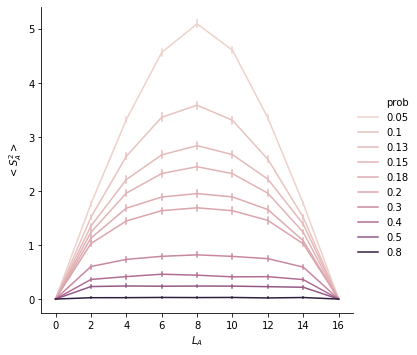

In [520]:
df0 = pd.DataFrame(renyi_result)
#df0 = df0.groupby(['size_a','prob']).mean().reset_index()
SizeandRenyi = snb.relplot(x='size_a', y='renyi', hue='prob', kind ='line', err_style='bars', legend='full', data=df0)
SizeandRenyi.set(xlabel = '$L_A$', ylabel = '$ < S_A^{2} > $')
plt.savefig('figure1.eps')
df0.to_csv(r'S_LA_L16.csv', index = False)

### Compute $S_A \sim t$

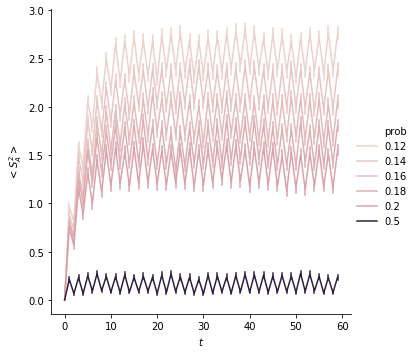

In [522]:
df1 = pd.DataFrame(renyi_result2)
#df1 = df1.groupby(['t','prob']).mean().reset_index()
timeandrenyi = snb.relplot(x='t', y='renyi', hue='prob', kind='line', err_style='bars', legend='full', data=df1)
timeandrenyi.set(xlabel = '$t$', ylabel = '$ < S_A^{2} > $')
plt.savefig('figure2.eps')
df1.to_csv(r'S_t_L14.csv', index = False)

## System BMI ($l/6$)

## System TMI ($l/4$) --  negativity

## Strong Ancilla Coupling -- the mutual info between two ancilla

In [587]:
%%time
length = [10, 12, 14]
bimutual_anctwo = []

for prob in np.arange(0, 0.48, 0.03):
    for j in range(1000):
        for k in length:
            systems = [[k, k + 1], [k + 1, k + 2]]
            psi = np.zeros(2**(k+2))
            psi[2**(k+1)] = 1
            bimutual_p_anc = evolution4(psi, k+2, prob, 40, k, k, 0, k//2+1, 6, systems)
            result5 = dict(prob = prob, length = k, bimutual_p_anc = bimutual_p_anc)
            bimutual_anctwo.append(result5)  

CPU times: user 5h 13min 17s, sys: 7min 3s, total: 5h 20min 20s
Wall time: 2h 45min 39s


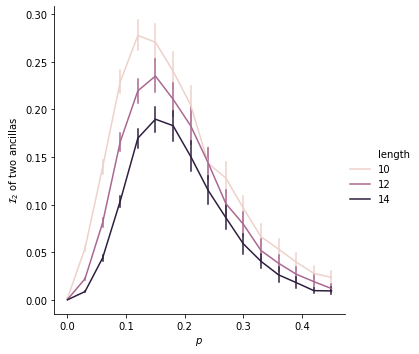

In [626]:
bimutdf3 = pd.DataFrame(bimutual_anctwo)
#bimutdf3 = bimutdf3.groupby(['length','prob']).mean().reset_index()
bimutofancilla = snb.relplot(x='prob', y='bimutual_p_anc', hue='length', kind='line', err_style='bars', legend='full', data=bimutdf3)
bimutofancilla.set(xlabel = '$p$', ylabel = '$ \mathcal{I}_2 $ of two ancillas')
plt.savefig('figure4.eps')
bimutdf3.to_csv(r'S_twoancillastrongcoup.csv', index = False)